In [50]:
import pandas as pd
import numpy as np
import pylab as pl
import datetime as dt
import os
import requests
import math
import datetime
from scipy.interpolate import spline
import matplotlib as mpl
import matplotlib.pyplot as plt
# The two statemens below are used mainly to set up a plotting
# default style that's better than the default from Matplotlib 1.x
# Matplotlib 2.0 supposedly has better default styles.
import seaborn as sns
plt.style.use('bmh')

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import seaborn

In [115]:
def download_file(url, filename):
    """
    Helper method handling downloading large files from `url` to `filename`. Returns a pointer to `filename`.
    """
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    return filename

In [116]:
#Get and clean traffic data
data = download_file("https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD",
                    "NYPD_Motor_Vehicle_Collisions.csv")
df = pd.read_csv(data, index_col=23)
df.head()

/Users/alexandershannon/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
UNIQUE KEY,,,,,,,,,,,,,,,,,,,,,
3800783,12/01/2017,0:00,BROOKLYN,11218,40.638214,-73.96849,"(40.638214, -73.96849)",NaN,NaN,781 CONEY ISLAND AVENUE,...,Failure to Keep Right,Unspecified,NaN,NaN,NaN,DP,van,NaN,NaN,NaN
3801709,12/01/2017,0:00,MANHATTAN,10019,NaN,NaN,NaN,West 57 Street,6 1/2 Avenue,NaN,...,Driver Inattention/Distraction,Unspecified,Unspecified,NaN,NaN,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN
3800960,12/01/2017,0:00,QUEENS,11385,40.702568,-73.89314,"(40.702568, -73.89314)",SHALER AVENUE,64 STREET,NaN,...,Reaction to Other Uninvolved Vehicle,NaN,NaN,NaN,NaN,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN
3802079,12/01/2017,0:00,NaN,NaN,40.737553,-74.00569,"(40.737553, -74.00569)",HUDSON STREET,NaN,NaN,...,Unspecified,NaN,NaN,NaN,NaN,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN
3800759,12/01/2017,0:00,NaN,NaN,40.745384,-73.76879,"(40.745384, -73.76879)",NaN,NaN,NaN,...,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,SPORT UTILITY / STATION WAGON,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN


In [118]:
weather_data.head()

,max_temp(F),min_temp(F),avg_wind_speed,rain_status,total_precipitation(in),snow_status,snowfall(in),snow_depth(in),fog_status,drizzle_status,ice_sleet_hail_status,date
DATE,,,,,,,,,,,,
2012-06-01,74,62,8.05,1.0,0.25,NaN,0.0,0,1.0,NaN,NaN,2012-06-01
2012-06-02,75,61,5.14,1.0,0.39,NaN,0.0,0,1.0,NaN,NaN,2012-06-02
2012-06-03,76,58,5.37,1.0,0.01,NaN,0.0,0,NaN,NaN,NaN,2012-06-03
2012-06-04,63,54,7.61,1.0,0.18,NaN,0.0,0,1.0,NaN,NaN,2012-06-04
2012-06-05,64,51,3.80,1.0,0.01,NaN,0.0,0,NaN,NaN,NaN,2012-06-05


In [119]:
#get and clean weather data
weather_data = pd.read_csv('1135257.csv')
weather_data.set_index(['DATE'], inplace=True)

#Rename Columns to make more readible
weather_data.rename(columns={'AWND':'avg_wind_speed', 'PRCP':'total_precipitation(in)', 'SNOW':'snowfall(in)',
                     'SNWD':'snow_depth(in)', 'TMAX':'max_temp(F)','TMIN':'min_temp(F)', 'WT01':'fog_status',
                     'WT04':'ice_sleet_hail_status','WT14':'drizzle_status', 'WT16':'rain_status', 
                     'WT18':'snow_status'}, inplace=True)

#Drop columns irrelevant to our analysis
weather_data.drop(['STATION', 'NAME', 'WDF2', 'WDF5','WSF2','WSF5','WT02','WT06','WT08','WT13','WT19', 
                   'WT22', 'TAVG'], axis=1, inplace=True)

#Reorder columns to make more readible
weather_data = weather_data[['max_temp(F)', 'min_temp(F)', 'avg_wind_speed', 'rain_status','total_precipitation(in)',
                             'snow_status', 'snowfall(in)', 'snow_depth(in)', 'fog_status', 'drizzle_status', 
                             'ice_sleet_hail_status']]

weather_data['date'] = weather_data.index
weather_data['date'] = pd.to_datetime(weather_data['date'])

weather_data.head()

,max_temp(F),min_temp(F),avg_wind_speed,rain_status,total_precipitation(in),snow_status,snowfall(in),snow_depth(in),fog_status,drizzle_status,ice_sleet_hail_status,date
DATE,,,,,,,,,,,,
2012-06-01,74,62,8.05,1.0,0.25,NaN,0.0,0,1.0,NaN,NaN,2012-06-01
2012-06-02,75,61,5.14,1.0,0.39,NaN,0.0,0,1.0,NaN,NaN,2012-06-02
2012-06-03,76,58,5.37,1.0,0.01,NaN,0.0,0,NaN,NaN,NaN,2012-06-03
2012-06-04,63,54,7.61,1.0,0.18,NaN,0.0,0,1.0,NaN,NaN,2012-06-04
2012-06-05,64,51,3.80,1.0,0.01,NaN,0.0,0,NaN,NaN,NaN,2012-06-05


In [121]:
weather_data.head()

,max_temp(F),min_temp(F),avg_wind_speed,rain_status,total_precipitation(in),snow_status,snowfall(in),snow_depth(in),fog_status,drizzle_status,ice_sleet_hail_status,date
DATE,,,,,,,,,,,,
2012-06-01,74,62,8.05,1.0,0.25,NaN,0.0,0,1.0,NaN,NaN,2012-06-01
2012-06-02,75,61,5.14,1.0,0.39,NaN,0.0,0,1.0,NaN,NaN,2012-06-02
2012-06-03,76,58,5.37,1.0,0.01,NaN,0.0,0,NaN,NaN,NaN,2012-06-03
2012-06-04,63,54,7.61,1.0,0.18,NaN,0.0,0,1.0,NaN,NaN,2012-06-04
2012-06-05,64,51,3.80,1.0,0.01,NaN,0.0,0,NaN,NaN,NaN,2012-06-05


In [125]:
#df.rename(columns={'DATE':'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
UNIQUE KEY,,,,,,,,,,,,,,,,,,,,,
3800783,2017-12-01,0:00,BROOKLYN,11218,40.638214,-73.96849,"(40.638214, -73.96849)",NaN,NaN,781 CONEY ISLAND AVENUE,...,Failure to Keep Right,Unspecified,NaN,NaN,NaN,DP,van,NaN,NaN,NaN
3801709,2017-12-01,0:00,MANHATTAN,10019,NaN,NaN,NaN,West 57 Street,6 1/2 Avenue,NaN,...,Driver Inattention/Distraction,Unspecified,Unspecified,NaN,NaN,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN
3800960,2017-12-01,0:00,QUEENS,11385,40.702568,-73.89314,"(40.702568, -73.89314)",SHALER AVENUE,64 STREET,NaN,...,Reaction to Other Uninvolved Vehicle,NaN,NaN,NaN,NaN,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN
3802079,2017-12-01,0:00,NaN,NaN,40.737553,-74.00569,"(40.737553, -74.00569)",HUDSON STREET,NaN,NaN,...,Unspecified,NaN,NaN,NaN,NaN,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN
3800759,2017-12-01,0:00,NaN,NaN,40.745384,-73.76879,"(40.745384, -73.76879)",NaN,NaN,NaN,...,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,SPORT UTILITY / STATION WAGON,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN


In [119]:
df['LOCATION'].count()

950512

In [118]:
df['ZIP CODE'].count()

835380

In [ ]:
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data.head()

In [126]:
traffic_weather = df.merge(weather_data, on='date')
traffic_weather.head()

,date,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,min_temp(F),avg_wind_speed,rain_status,total_precipitation(in),snow_status,snowfall(in),snow_depth(in),fog_status,drizzle_status,ice_sleet_hail_status
0,2017-11-15,7:15,NaN,NaN,40.803980,-73.831085,"(40.80398, -73.831085)",NaN,NaN,NaN,...,37,5.14,NaN,0.0,NaN,0.0,0,NaN,NaN,NaN
1,2017-11-15,0:00,BROOKLYN,11233,40.676647,-73.916470,"(40.676647, -73.91647)",ATLANTIC AVENUE,SARATOGA AVENUE,NaN,...,37,5.14,NaN,0.0,NaN,0.0,0,NaN,NaN,NaN
2,2017-11-15,0:00,MANHATTAN,10004,40.701782,-74.011170,"(40.701782, -74.01117)",BROAD STREET,SOUTH STREET,NaN,...,37,5.14,NaN,0.0,NaN,0.0,0,NaN,NaN,NaN
3,2017-11-15,0:00,QUEENS,11364,40.737587,-73.768410,"(40.737587, -73.76841)",73 AVENUE,CLEARVIEW EXPRESSWAY,NaN,...,37,5.14,NaN,0.0,NaN,0.0,0,NaN,NaN,NaN
4,2017-11-15,0:00,QUEENS,11378,40.722897,-73.913860,"(40.722897, -73.91386)",RUST STREET,MASPETH AVENUE,NaN,...,37,5.14,NaN,0.0,NaN,0.0,0,NaN,NaN,NaN


In [106]:
traffic_weather.to_csv('traffic_and_weather.csv', encoding='utf-8')

In [104]:
%pwd

'/Users/alexandershannon/Downloads/TDV_Shapefile_AADT_2015'

In [105]:
traffic_weather.head()

NameError: name 'traffic_weather' is not defined

In [79]:
a

'11/15/2017'

In [5]:
%cd /Users/alexandershannon/Downloads/TDV_Shapefile_AADT_2015

/Users/alexandershannon/Downloads/TDV_Shapefile_AADT_2015


In [7]:
%ls

AADT_2015_tdv.dbf*     AADT_2015_tdv.sbx*     AADT_2015_tdv.shx*
AADT_2015_tdv.prj*     AADT_2015_tdv.shp*
AADT_2015_tdv.sbn*     AADT_2015_tdv.shp.xml*


In [9]:
import shapefile
shape = shapefile.Reader("AADT_2015_tdv.shp")
#first feature of the shapefile
feature = shape.shapeRecords()[0]
first = feature.shape.__geo_interface__  
print (first) # (GeoJSON format)
{'type': 'LineString', 'coordinates': ((0.0, 0.0), (25.0, 10.0), (50.0, 50.0))}


ModuleNotFoundError: No module named 'shapefile'

In [52]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# The two statemens below are used mainly to set up a plotting
# default style that's better than the default from Matplotlib 1.x
# Matplotlib 2.0 supposedly has better default styles.
import seaborn as sns
plt.style.use('bmh')

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import seaborn

data_pth = "../data"

In [55]:
%cd /Users/alexandershannon/Downloads/TDV_Shapefile_AADT_2015
AADT = GeoDataFrame.from_file('AADT_2015_tdv.shp')
#data.drop(['OBJECTID_1', 'OBJECTID', 'LOC_ERROR', 'AADT_YEAR'], axis=1, inplace=True)

/Users/alexandershannon/Downloads/TDV_Shapefile_AADT_2015


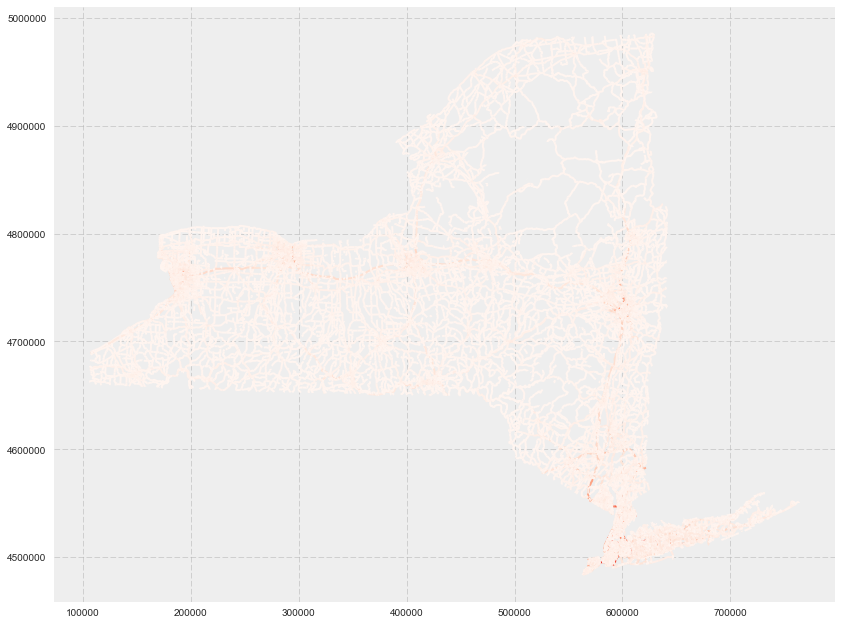

In [56]:
AADT.plot(column='AADT', cmap='Reds', figsize=(14,14))
plt.show()

In [57]:
AADT = AADT[AADT['MUNI'] == 'CITY OF NEW YORK']
AADT.head()

,OBJECTID_1,OBJECTID,RC_ID,LOC_ERROR,Shape_Leng,TDV_ROUTE,CC_ID,ROADWAYTYP,BEGINDESC,ENDDESC,...,AADT_YEAR,VOL_TXT,CLASS_TXT,SPEED_TXT,DATA_TYPE,VOL_TDV,CLASS_TDV,SPEED_TDV,Shape_Le_1,geometry
0,1,1,01_2053,NO ERROR,1166.162041,PITMAN AVE,,Road,BARNES AVE,SETON AVE,...,2015.0,Open Report - 2010,Open Report - No Class,Open Report - No Speed,VOLUME,/YR2010/R11/01_Bronx/01_2053.pdf,/YR2015/noclass.pdf,/YR2015/noSpeed.pdf,1166.162041,LINESTRING (596607.9900000002 4527724.56000000...
1,2,2,01_2000,NO ERROR,5308.008397,WHITE PLAINS RD,,Road,BOSTON RD,E 241ST ST,...,2015.0,Open Report - 2011,Open Report - No Class,Open Report - No Speed,VOLUME,/YR2011/R11/01_Bronx/01_2000.pdf,/YR2015/noclass.pdf,/YR2015/noSpeed.pdf,5308.008397,LINESTRING (595417.6699999999 4523667.83000000...
2,3,3,01_1114,NO ERROR,627.653516,BRONX PARK E,,Road,WHITE PLAINS R,BOSTON RD,...,2015.0,Open Report - 2011,Open Report - No Class,Open Report - No Speed,VOLUME,/YR2011/R11/01_Bronx/01_1114.pdf,/YR2015/noclass.pdf,/YR2015/noSpeed.pdf,627.653516,LINESTRING (595429.790000001 4522723.240000002...
3,4,4,01_1255,NO ERROR,658.237350,WILLIMSBRDG RD,,Road,BOSTON RD,ADEE AVE,...,2015.0,Open Report - 2010,Open Report - No Class,Open Report - No Speed,VOLUME,/YR2010/R11/01_Bronx/01_1255.pdf,/YR2015/noclass.pdf,/YR2015/noSpeed.pdf,658.237350,LINESTRING (596005.1500000013 4524587.10000000...
4,5,5,01_0055,NO ERROR,193.074488,"9A, HENRY HUDSON PK",,Route,END 9A/907V OLAP & RT 9 OVER,START 9/9A OLAP,...,2015.0,Open Report - No Data,Open Report - No Class,Open Report - No Speed,NO DATA,/YR2015/nodata.pdf,/YR2015/noclass.pdf,/YR2015/noSpeed.pdf,193.074488,LINESTRING (592913.0877333404 4528262.97920000...


In [58]:
len(AADT)

6157

Index(['OBJECTID_1', 'OBJECTID', 'RC_ID', 'LOC_ERROR', 'Shape_Leng',
       'TDV_ROUTE', 'CC_ID', 'ROADWAYTYP', 'BEGINDESC', 'ENDDESC', 'MUNI',
       'AADT', 'AADT_TYPE', 'AADT_YEAR', 'VOL_TXT', 'CLASS_TXT', 'SPEED_TXT',
       'DATA_TYPE', 'VOL_TDV', 'CLASS_TDV', 'SPEED_TDV', 'Shape_Le_1',
       'geometry'],
      dtype='object')

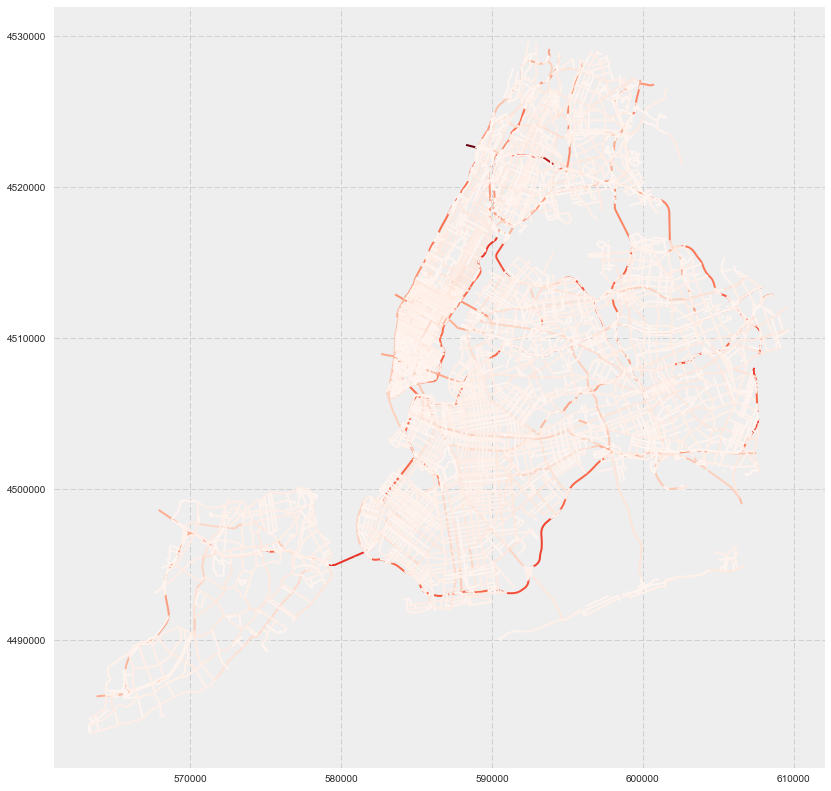

In [59]:
AADT.plot(column='AADT', cmap='Reds', figsize=(14,14))
plt.show()

In [60]:
# https://geo.nyu.edu/catalog/nyu_2451_34509
%cd /Users/alexandershannon/Downloads/nyu_2451_34509
zip_codes = GeoDataFrame.from_file('nyu_2451_34509.shp')

/Users/alexandershannon/Downloads/nyu_2451_34509


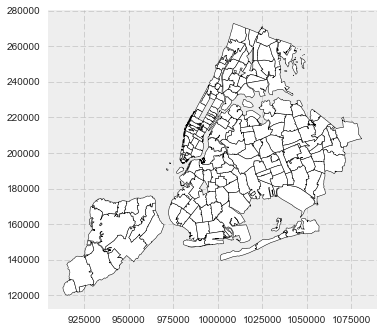

In [61]:
zip_codes.plot(color="white", edgecolor="black")
plt.show()

In [62]:
%cd /Users/alexandershannon/Downloads
crime_data = GeoDataFrame.from_file('nyu_2451_34509.shp')

/Users/alexandershannon/Downloads


OSError: no such file or directory: 'nyu_2451_34509.shp'

In [63]:
url = 'https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD'
crime_data = pd.read_csv(url)
crime_data.head()

/Users/alexandershannon/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,44.0,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)"
1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,103.0,OUTSIDE,NaN,NaN,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)"
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,28.0,NaN,OTHER,NaN,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)"
3,968417082,12/31/2015,23:30:00,NaN,NaN,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,105.0,INSIDE,RESIDENCE-HOUSE,NaN,NaN,1060183.0,177862.0,40.654549,-73.726339,"(40.654549444, -73.726338791)"
4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,13.0,FRONT OF,OTHER,NaN,NaN,987606.0,208148.0,40.738002,-73.987891,"(40.7380024, -73.98789129)"


In [65]:
crime_data.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC',
       'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'JURIS_DESC', 'BORO_NM',
       'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'PARKS_NM',
       'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude',
       'Lat_Lon'],
      dtype='object')

In [110]:
demographic = pd.read_csv('Demographic_Statistics_By_Zip_Code.csv')
demographic.head()

,JURISDICTION NAME,COUNT PARTICIPANTS,COUNT FEMALE,PERCENT FEMALE,COUNT MALE,PERCENT MALE,COUNT GENDER UNKNOWN,PERCENT GENDER UNKNOWN,COUNT GENDER TOTAL,PERCENT GENDER TOTAL,...,COUNT CITIZEN STATUS TOTAL,PERCENT CITIZEN STATUS TOTAL,COUNT RECEIVES PUBLIC ASSISTANCE,PERCENT RECEIVES PUBLIC ASSISTANCE,COUNT NRECEIVES PUBLIC ASSISTANCE,PERCENT NRECEIVES PUBLIC ASSISTANCE,COUNT PUBLIC ASSISTANCE UNKNOWN,PERCENT PUBLIC ASSISTANCE UNKNOWN,COUNT PUBLIC ASSISTANCE TOTAL,PERCENT PUBLIC ASSISTANCE TOTAL
0,10001,44,22,0.50,22,0.50,0,0,44,100,...,44,100,20,0.45,24,0.55,0,0,44,100
1,10002,35,19,0.54,16,0.46,0,0,35,100,...,35,100,2,0.06,33,0.94,0,0,35,100
2,10003,1,1,1.00,0,0.00,0,0,1,100,...,1,100,0,0.00,1,1.00,0,0,1,100
3,10004,0,0,0.00,0,0.00,0,0,0,0,...,0,0,0,0.00,0,0.00,0,0,0,0
4,10005,2,2,1.00,0,0.00,0,0,2,100,...,2,100,0,0.00,2,1.00,0,0,2,100


In [117]:
zip_codes.rename(columns={'zcta':'zip_code'}, inplace=True)
zip_codes.drop(['note','bcode'], axis=1, inplace=True)
zip_codes.head()

,zip_code,geometry
0,10001,"POLYGON ((983229.2383424834 211922.5816751101,..."
1,10002,"POLYGON ((985096.3850784544 198703.5457405522,..."
2,10003,"POLYGON ((986450.4858028748 203647.5975069208,..."
3,10004,"(POLYGON ((976856.663963466 189102.0183191186,..."
4,10005,"POLYGON ((981746.6308157594 196240.0595342411,..."


In [114]:
demographic.rename(columns={'JURISDICTION NAME': 'zip_code'}, inplace=True)

In [124]:
demographic.zip_code = demographic.zip_code.astype(str)

In [125]:
demographic.zip_code.iloc[0]

'10001'

In [126]:
zip_codes.zip_code.iloc[0] == demographic.zip_code.iloc[0]

True

In [127]:
dem_zip = demographic.merge(zip_codes, how='inner', on='zip_code')
dem_zip.head()

,zip_code,COUNT PARTICIPANTS,COUNT FEMALE,PERCENT FEMALE,COUNT MALE,PERCENT MALE,COUNT GENDER UNKNOWN,PERCENT GENDER UNKNOWN,COUNT GENDER TOTAL,PERCENT GENDER TOTAL,...,PERCENT CITIZEN STATUS TOTAL,COUNT RECEIVES PUBLIC ASSISTANCE,PERCENT RECEIVES PUBLIC ASSISTANCE,COUNT NRECEIVES PUBLIC ASSISTANCE,PERCENT NRECEIVES PUBLIC ASSISTANCE,COUNT PUBLIC ASSISTANCE UNKNOWN,PERCENT PUBLIC ASSISTANCE UNKNOWN,COUNT PUBLIC ASSISTANCE TOTAL,PERCENT PUBLIC ASSISTANCE TOTAL,geometry
0,10001,44,22,0.50,22,0.50,0,0,44,100,...,100,20,0.45,24,0.55,0,0,44,100,"POLYGON ((983229.2383424834 211922.5816751101,..."
1,10002,35,19,0.54,16,0.46,0,0,35,100,...,100,2,0.06,33,0.94,0,0,35,100,"POLYGON ((985096.3850784544 198703.5457405522,..."
2,10003,1,1,1.00,0,0.00,0,0,1,100,...,100,0,0.00,1,1.00,0,0,1,100,"POLYGON ((986450.4858028748 203647.5975069208,..."
3,10004,0,0,0.00,0,0.00,0,0,0,0,...,0,0,0.00,0,0.00,0,0,0,0,"(POLYGON ((976856.663963466 189102.0183191186,..."
4,10005,2,2,1.00,0,0.00,0,0,2,100,...,100,0,0.00,2,1.00,0,0,2,100,"POLYGON ((981746.6308157594 196240.0595342411,..."


In [128]:
crs = {'init': 'epsg:4326'}
demographic_gdf = GeoDataFrame(dem_zip, crs=crs, geometry=dem_zip.geometry)
demographic_gdf.head()

,zip_code,COUNT PARTICIPANTS,COUNT FEMALE,PERCENT FEMALE,COUNT MALE,PERCENT MALE,COUNT GENDER UNKNOWN,PERCENT GENDER UNKNOWN,COUNT GENDER TOTAL,PERCENT GENDER TOTAL,...,PERCENT CITIZEN STATUS TOTAL,COUNT RECEIVES PUBLIC ASSISTANCE,PERCENT RECEIVES PUBLIC ASSISTANCE,COUNT NRECEIVES PUBLIC ASSISTANCE,PERCENT NRECEIVES PUBLIC ASSISTANCE,COUNT PUBLIC ASSISTANCE UNKNOWN,PERCENT PUBLIC ASSISTANCE UNKNOWN,COUNT PUBLIC ASSISTANCE TOTAL,PERCENT PUBLIC ASSISTANCE TOTAL,geometry
0,10001,44,22,0.50,22,0.50,0,0,44,100,...,100,20,0.45,24,0.55,0,0,44,100,"POLYGON ((983229.2383424834 211922.5816751101,..."
1,10002,35,19,0.54,16,0.46,0,0,35,100,...,100,2,0.06,33,0.94,0,0,35,100,"POLYGON ((985096.3850784544 198703.5457405522,..."
2,10003,1,1,1.00,0,0.00,0,0,1,100,...,100,0,0.00,1,1.00,0,0,1,100,"POLYGON ((986450.4858028748 203647.5975069208,..."
3,10004,0,0,0.00,0,0.00,0,0,0,0,...,0,0,0.00,0,0.00,0,0,0,0,"(POLYGON ((976856.663963466 189102.0183191186,..."
4,10005,2,2,1.00,0,0.00,0,0,2,100,...,100,0,0.00,2,1.00,0,0,2,100,"POLYGON ((981746.6308157594 196240.0595342411,..."


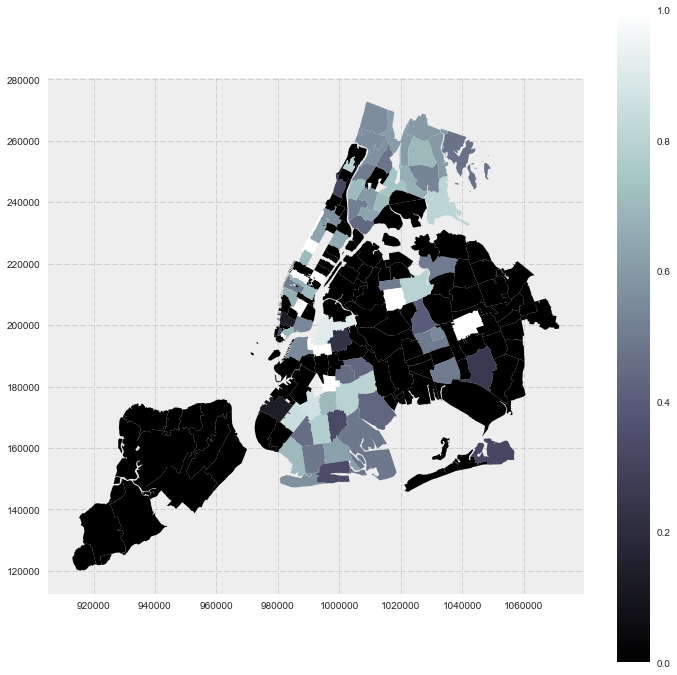

In [139]:
import seaborn
explore = 'PERCENT FEMALE'
demographic_gdf.plot(column=explore, cmap='bone', legend=True, figsize=(12,12))
plt.show()

In [4]:
%cd Downloads

/Users/alexandershannon/Downloads


In [5]:
import pandas as pd
import numpy as np

In [75]:
demograph = pd.read_excel('15zp33ny.xls', skiprows=3, header=0)
demograph = demograph.iloc[10::8]
demograph.head()

,ZIP code [1],Size of adjusted gross income,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,Number of dependents,Number of volunteer prepared returns [2],...,Total tax liability [10],Unnamed: 120,Additional Medicare tax,Unnamed: 122,Net investment income tax,Unnamed: 124,Tax due at time of filing [11],Unnamed: 126,Overpayments refunded [12],Unnamed: 128
10,10001,NaN,14310.0,10310.0,2540.0,1070.0,8790.0,19710.0,3240.0,380,...,12360,540407,1990,6211,1720,9506,3770,46475,9320,44852
18,10002,NaN,43190.0,25620.0,10860.0,5910.0,29400.0,71450.0,18550.0,1350,...,29480,363292,1250,2437,1090,2277,9330,37830,30730,82778
26,10003,NaN,30050.0,22890.0,5550.0,950.0,19340.0,39470.0,4840.0,290,...,27350,1802168,5230,20017,5000,52957,8880,123940,17780,154363
34,10004,NaN,2490.0,1420.0,830.0,130.0,1670.0,4380.0,1130.0,0,...,2290,254473,710,3185,630,6854,820,22311,1410,18708
42,10005,NaN,6160.0,4450.0,1370.0,140.0,3640.0,8600.0,1400.0,0,...,5760,894882,1200,4788,1280,57581,1590,29671,3810,166131


In [76]:
demograph.drop(['Size of adjusted gross income', 'Number with paid preparer\'s signature',
                'Total tax liability [10]', 'Unnamed: 120', 'Additional Medicare tax',
                'Unnamed: 122', 'Net investment income tax', 'Unnamed: 124',
                'Tax due at time of filing [11]', 'Unnamed: 126',
                'Overpayments refunded [12]', 'Unnamed: 128'],axis=1,inplace=True)
demograph.drop(['Excess earned income credit \n(refundable) [8]', 'Unnamed: 110',
                'Additional child tax credit', 'Unnamed: 112',
                'Refundable education credit', 'Unnamed: 114', 'Net premium tax credit',
                'Unnamed: 116', 'Income tax [9]', 'Unnamed: 118','Number of volunteer prepared returns [2]', 
                'Unnamed: 10', 'Unnamed: 11'],axis=1,inplace=True)
demograph.drop(['Number of refund anticipation loan returns',
                'Number of refund anticipation check returns','Total premium tax credit', 'Unnamed: 100',
                'Advance premium tax credit', 'Unnamed: 102','Health care individual responsibility payment', 
                'Unnamed: 104','Total tax payments', 'Unnamed: 106', 'Earned income credit [7]',
                'Unnamed: 108'],axis=1,inplace=True)
demograph.drop(['Unnamed: 12','Unnamed: 18','Unnamed: 20', 'Taxable interest', 'Unnamed: 22', 'Ordinary dividends',
                'Unnamed: 24', 'Qualified dividends [5]', 'Unnamed: 26',
                'State and local income tax refunds\n', 'Unnamed: 28',
                'Business or profession\nnet income (less loss)', 'Unnamed: 30',
                'Net capital gain (less loss) in AGI', 'Unnamed: 32',
                'Taxable individual retirement\narrangement distributions',
                'Unnamed: 34', 'Pensions and annuities in AGI', 'Unnamed: 36',
                'Number of \nfarm returns'],axis=1,inplace=True)
demograph.drop(['Unnamed: 39','Taxable Social Security benefits', 'Unnamed: 41',
                'Partnership/S-corp net income (less loss)', 'Unnamed: 43',
                'Total statuory adjustments', 'Unnamed: 45', 'Educator expenses',
                'Unnamed: 47', 'Self-employment retirement plans', 'Unnamed: 49',
                'Self-employment health insurance deduction', 'Unnamed: 51',
                'IRA payments', 'Unnamed: 53', 'Student loan interest deduction',
                'Unnamed: 55', 'Tuition and fees deduction', 'Unnamed: 57',
                'Domestic production activities deduction', 'Unnamed: 59',
                'Total itemized deductions', 'Unnamed: 61', 'Unnamed: 62',
                'State and local income taxes', 'Unnamed: 64',
                'State and local general sales taxes', 'Unnamed: 66',
                'Real estate taxes', 'Unnamed: 68', 'Taxes paid', 'Unnamed: 70',
                'Mortgage interest paid', 'Unnamed: 72', 'Contributions', 'Unnamed: 74',
                'Taxable income', 'Unnamed: 76', 'Income tax before credits',
                'Unnamed: 78', 'Alternative minimum tax', 'Unnamed: 80',
                'Excess advance premium tax credit repayment', 'Unnamed: 82',
                'Total tax credits', 'Unnamed: 84', 'Foreign tax credit', 'Unnamed: 86',
                'Child and dependent care credit', 'Unnamed: 88',
                'Nonrefundable education credit', 'Unnamed: 90',
                'Retirement savings contribution credit', 'Unnamed: 92',
                'Child tax credit', 'Unnamed: 94', 'Residential energy tax credit',
                'Unnamed: 96', 'Self-employment tax', 'Unnamed: 98'],axis=1,inplace=True)

In [77]:
demograph['zip_code'] = demograph['	ZIP code [1]']
demograph['avg_family_income'] = (demograph['Adjusted gross income (AGI) [4]'] * 1000) / demograph['Total income']
demograph['elderly_pop_percentage'] = demograph['Number of elderly returns [3]'] / demograph['Number of returns']
demograph['dependant_pop_percentage'] = demograph['Number of dependents'] / demograph['Number of returns']
demograph['single_pop_percentage'] = demograph['Number of single returns'] / demograph['Number of returns']
demograph['unemployment_pop_percentage'] = demograph['Unemployment compensation [6]'] / demograph['Number of returns']

demograph.reset_index(inplace=True)
demograph.drop(['Number of single returns', 'Number of joint returns', 'Number of head of household returns',
                'Number of exemptions', 'Number of dependents', 'Number of elderly returns [3]',
                'Adjusted gross income (AGI) [4]', 'Total income', 'Salaries and wages in AGI',
                'Unemployment compensation [6]', 'index'],axis=1,inplace=True)
demograph.rename(columns={'ZIP\ncode [1]':'zip_code', 'Number of returns':'num_returns'}, inplace=True)
demograph.head()

,ZIP code [1],Number of returns,avg_family_income,elderly_pop_percentage,dependant_pop_percentage,single_pop_percentage,unemployment_pop_percentage
0,10001,14310.0,165548,0.174703,0.226415,0.720475,0.0293501
1,10002,43190.0,53305,0.173651,0.429498,0.593193,0.0245427
2,10003,30050.0,248251,0.188353,0.161065,0.761730,0.0216306
3,10004,2490.0,404103,0.096386,0.453815,0.570281,0.0200803
4,10005,6160.0,614330,0.071429,0.227273,0.722403,0.0162338


In [84]:
demograph.head()

,zip_code,num_returns,avg_family_income,elderly_pop_percentage,dependant_pop_percentage,single_pop_percentage,unemployment_pop_percentage
0,10001,14310.0,165548,0.174703,0.226415,0.720475,0.0293501
1,10002,43190.0,53305,0.173651,0.429498,0.593193,0.0245427
2,10003,30050.0,248251,0.188353,0.161065,0.761730,0.0216306
3,10004,2490.0,404103,0.096386,0.453815,0.570281,0.0200803
4,10005,6160.0,614330,0.071429,0.227273,0.722403,0.0162338


In [91]:
zip_codes.rename(columns={'zcta':'zip_code'}, inplace=True)
zip_codes.drop(['bcode', 'note'], axis=1, inplace=True)
zip_codes.zip_code = zip_codes.zip_code.astype(int)
zip_codes.head()

,zip_code,geometry
0,10001,"POLYGON ((983229.2383424834 211922.5816751101,..."
1,10002,"POLYGON ((985096.3850784544 198703.5457405522,..."
2,10003,"POLYGON ((986450.4858028748 203647.5975069208,..."
3,10004,"(POLYGON ((976856.663963466 189102.0183191186,..."
4,10005,"POLYGON ((981746.6308157594 196240.0595342411,..."


In [92]:
zip_codes.zip_code.iloc[0]

10001

In [93]:
dem_zip = demograph.merge(zip_codes, how='inner', on='zip_code')
dem_zip.head()

,zip_code,num_returns,avg_family_income,elderly_pop_percentage,dependant_pop_percentage,single_pop_percentage,unemployment_pop_percentage,geometry
0,10001,14310.0,165548,0.174703,0.226415,0.720475,0.0293501,"POLYGON ((983229.2383424834 211922.5816751101,..."
1,10002,43190.0,53305,0.173651,0.429498,0.593193,0.0245427,"POLYGON ((985096.3850784544 198703.5457405522,..."
2,10003,30050.0,248251,0.188353,0.161065,0.761730,0.0216306,"POLYGON ((986450.4858028748 203647.5975069208,..."
3,10004,2490.0,404103,0.096386,0.453815,0.570281,0.0200803,"(POLYGON ((976856.663963466 189102.0183191186,..."
4,10005,6160.0,614330,0.071429,0.227273,0.722403,0.0162338,"POLYGON ((981746.6308157594 196240.0595342411,..."


In [96]:
crs = {'init': 'epsg:4326'}
demographic_gdf = GeoDataFrame(dem_zip, crs=crs, geometry=dem_zip.geometry)
demographic_gdf.head()

,zip_code,num_returns,avg_family_income,elderly_pop_percentage,dependant_pop_percentage,single_pop_percentage,unemployment_pop_percentage,geometry
0,10001,14310.0,165548,0.174703,0.226415,0.720475,0.0293501,"POLYGON ((983229.2383424834 211922.5816751101,..."
1,10002,43190.0,53305,0.173651,0.429498,0.593193,0.0245427,"POLYGON ((985096.3850784544 198703.5457405522,..."
2,10003,30050.0,248251,0.188353,0.161065,0.761730,0.0216306,"POLYGON ((986450.4858028748 203647.5975069208,..."
3,10004,2490.0,404103,0.096386,0.453815,0.570281,0.0200803,"(POLYGON ((976856.663963466 189102.0183191186,..."
4,10005,6160.0,614330,0.071429,0.227273,0.722403,0.0162338,"POLYGON ((981746.6308157594 196240.0595342411,..."


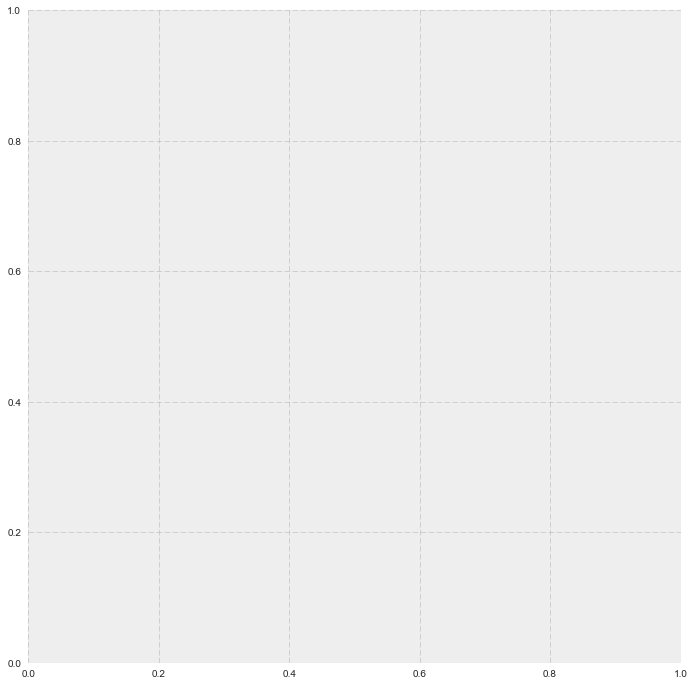

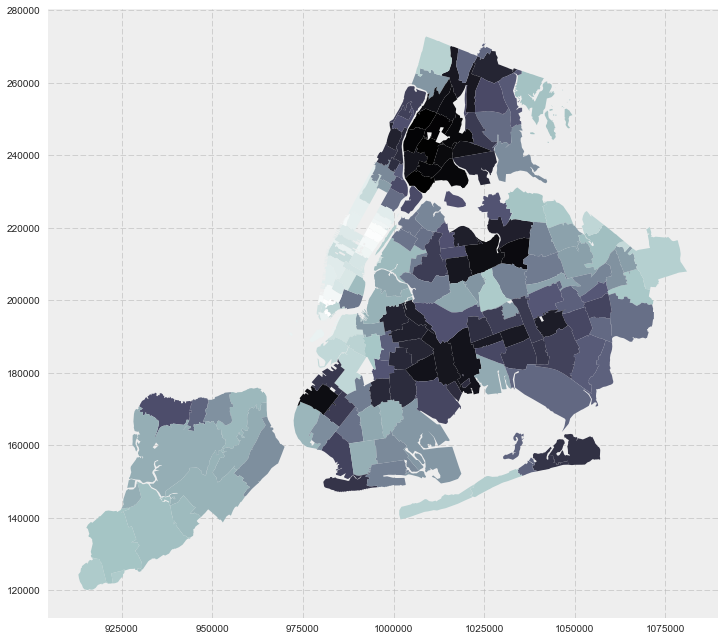

In [103]:
import seaborn
explore = 'avg_family_income'
demographic_gdf.plot(column=explore, cmap='bone', figsize=(12,12))
plt.show()

# Check these out

In [104]:
import pandas as pd
import numpy as np
import pylab as pl
import datetime as dt
import os
import requests
import math
import datetime
from scipy.interpolate import spline
import matplotlib as mpl
import matplotlib.pyplot as plt
# The two statemens below are used mainly to set up a plotting
# default style that's better than the default from Matplotlib 1.x
# Matplotlib 2.0 supposedly has better default styles.
import seaborn as sns
plt.style.use('bmh')

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import seaborn

In [112]:
#AADT.to_csv('AADT.csv')
AADT.head(3)

,OBJECTID_1,OBJECTID,RC_ID,LOC_ERROR,Shape_Leng,TDV_ROUTE,CC_ID,ROADWAYTYP,BEGINDESC,ENDDESC,...,AADT_YEAR,VOL_TXT,CLASS_TXT,SPEED_TXT,DATA_TYPE,VOL_TDV,CLASS_TDV,SPEED_TDV,Shape_Le_1,geometry
0,1,1,01_2053,NO ERROR,1166.162041,PITMAN AVE,,Road,BARNES AVE,SETON AVE,...,2015.0,Open Report - 2010,Open Report - No Class,Open Report - No Speed,VOLUME,/YR2010/R11/01_Bronx/01_2053.pdf,/YR2015/noclass.pdf,/YR2015/noSpeed.pdf,1166.162041,LINESTRING (596607.9900000002 4527724.56000000...
1,2,2,01_2000,NO ERROR,5308.008397,WHITE PLAINS RD,,Road,BOSTON RD,E 241ST ST,...,2015.0,Open Report - 2011,Open Report - No Class,Open Report - No Speed,VOLUME,/YR2011/R11/01_Bronx/01_2000.pdf,/YR2015/noclass.pdf,/YR2015/noSpeed.pdf,5308.008397,LINESTRING (595417.6699999999 4523667.83000000...
2,3,3,01_1114,NO ERROR,627.653516,BRONX PARK E,,Road,WHITE PLAINS R,BOSTON RD,...,2015.0,Open Report - 2011,Open Report - No Class,Open Report - No Speed,VOLUME,/YR2011/R11/01_Bronx/01_1114.pdf,/YR2015/noclass.pdf,/YR2015/noSpeed.pdf,627.653516,LINESTRING (595429.790000001 4522723.240000002...


In [113]:
#demographic_gdf.to_csv('demographic_gdf.csv')
demographic_gdf.head(3)

,zip_code,num_returns,avg_family_income,elderly_pop_percentage,dependant_pop_percentage,single_pop_percentage,unemployment_pop_percentage,geometry
0,10001,14310.0,165548,0.174703,0.226415,0.720475,0.0293501,"POLYGON ((983229.2383424834 211922.5816751101,..."
1,10002,43190.0,53305,0.173651,0.429498,0.593193,0.0245427,"POLYGON ((985096.3850784544 198703.5457405522,..."
2,10003,30050.0,248251,0.188353,0.161065,0.761730,0.0216306,"POLYGON ((986450.4858028748 203647.5975069208,..."


In [114]:
#crime_data.to_csv('crime_data.csv')
crime_data.head(3)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,44.0,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)"
1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,103.0,OUTSIDE,NaN,NaN,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)"
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,28.0,NaN,OTHER,NaN,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)"


In [127]:
#traffic_weather.to_csv('traffic_weather.csv')
traffic_weather.head()

,date,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,min_temp(F),avg_wind_speed,rain_status,total_precipitation(in),snow_status,snowfall(in),snow_depth(in),fog_status,drizzle_status,ice_sleet_hail_status
0,2017-11-15,7:15,NaN,NaN,40.803980,-73.831085,"(40.80398, -73.831085)",NaN,NaN,NaN,...,37,5.14,NaN,0.0,NaN,0.0,0,NaN,NaN,NaN
1,2017-11-15,0:00,BROOKLYN,11233,40.676647,-73.916470,"(40.676647, -73.91647)",ATLANTIC AVENUE,SARATOGA AVENUE,NaN,...,37,5.14,NaN,0.0,NaN,0.0,0,NaN,NaN,NaN
2,2017-11-15,0:00,MANHATTAN,10004,40.701782,-74.011170,"(40.701782, -74.01117)",BROAD STREET,SOUTH STREET,NaN,...,37,5.14,NaN,0.0,NaN,0.0,0,NaN,NaN,NaN
3,2017-11-15,0:00,QUEENS,11364,40.737587,-73.768410,"(40.737587, -73.76841)",73 AVENUE,CLEARVIEW EXPRESSWAY,NaN,...,37,5.14,NaN,0.0,NaN,0.0,0,NaN,NaN,NaN
4,2017-11-15,0:00,QUEENS,11378,40.722897,-73.913860,"(40.722897, -73.91386)",RUST STREET,MASPETH AVENUE,NaN,...,37,5.14,NaN,0.0,NaN,0.0,0,NaN,NaN,NaN
